In [1]:
from matplotlib import pyplot as plt
import numpy as np
from train import load_datasets, create_inceptionv3_model, train_model
# autoreload
%load_ext autoreload
%autoreload 2

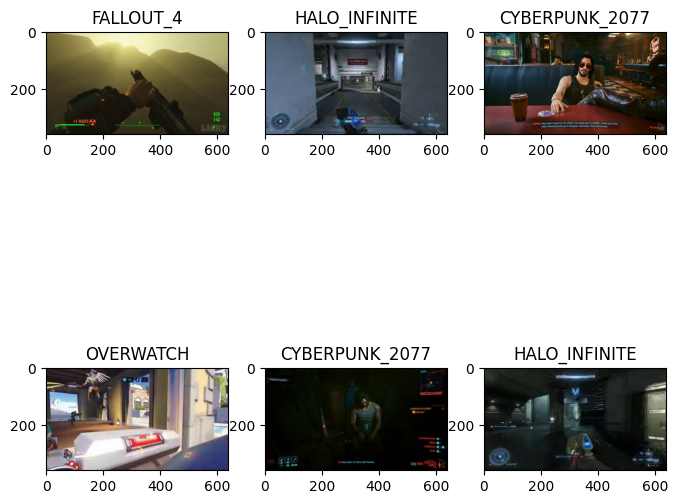

In [22]:
train_dataset, val_dataset, test_dataset = load_datasets("./dataset/processed", None)

# example
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 2
for i in range(1, cols * rows + 1):
    sample_idx = np.random.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    
    figure.add_subplot(rows, cols, i)
    plt.title(train_dataset.classes[label])
    plt.imshow(img.numpy().transpose(1,2,0))
plt.show()


In [27]:
import torch


model = create_inceptionv3_model(len(train_dataset.classes))
outputs, _ = model(train_dataset[0][0].unsqueeze(0))
print(outputs)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
start_epoch = 0

tensor([[ 0.3158,  0.0016, -0.3459,  0.1677, -0.0165,  0.0826,  0.5131,  0.3294,
          0.3474, -0.1729,  0.0625,  0.2427, -0.5190, -0.5251,  0.3858,  0.4814,
          0.0619, -0.0779, -0.0400,  0.2428, -0.7659, -0.2578,  0.3162, -0.0291,
          0.1911,  0.5908,  0.1716,  0.3549,  0.1387, -0.1193]],
       grad_fn=<AddmmBackward0>)


In [28]:
# Load model if provided
from train import load_model
continue_training_from = None
if continue_training_from:
    model, optimizer, start_epoch = load_model(continue_training_from, model, optimizer)

In [29]:
from train import train_model, test_model, inceptionv3_predict_fix

train_model(
    model,
    train_dataset,
    num_epochs=10,
    cur_epoch=start_epoch,
    optimizer=optimizer,
    batch_size=16,
    limit_dataset_size=10000,
    val_dataset=val_dataset,
    val_every=100,
    val_sample_size=300,
    predict_fix=inceptionv3_predict_fix,
)
# test_inceptionv3(model, test_dataset, batch_size=1, limit_dataset_size=1000)

Epoch 1/10:   0%|          | 2/10000 [00:09<11:10:09,  4.02s/it, Loss=6.68]

Batch [0/10000] Validation accuracy: 0.00%


KeyboardInterrupt: 